In [16]:
import re
import os
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from google.colab import drive
from skimage.io import imread
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as ks 

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import cv2
arr=[]
labels = []
num_nonfaces =[]
image1 =[]
accff=[]
i=0
nonfaces=0
for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset2"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg"): 
        nonfaces = nonfaces + 1 
        #image1 = io.imread(os.path.join(root,name))
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))  
      res=re.findall('(\d+)',root_folder[1]) ##
      #image1 = image.imread(os.path.join(root,name))
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      #print(image1)
      arr.append(image1)
      labels.append(int(res[0]))
      i=i+1
num_nonfaces.append( nonfaces)     
arr=np.array(arr)   
labels=np.array(labels)    
print(labels.shape)       
print(arr.shape)
#print(labels)      

(599,)
(599, 10304)


In [19]:
print(labels.shape)       
print(arr.shape)
#print(labels)

(599,)
(599, 10304)


In [25]:
# adding the data to a dataframe
df = pd.DataFrame(arr) 
df['label'] = pd.DataFrame(labels)
# sorting the data according to labels
df.sort_values("label", inplace=True)
df.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,label
326,107,103,104,102,105,103,105,103,106,102,...,143,152,151,152,175,167,155,133,159,2
325,109,110,113,111,112,110,111,112,110,112,...,56,50,50,54,52,55,49,52,51,2
324,58,55,52,54,55,53,55,57,48,58,...,54,54,101,93,112,142,131,115,68,2
334,49,65,53,56,51,61,54,55,59,53,...,67,55,92,101,94,121,134,130,145,2
598,155,154,153,157,154,156,153,153,155,153,...,137,141,135,123,112,111,113,110,111,2


In [26]:
# seperating images from labels
Y = np.array(df['label'])
df = df.drop(axis=1, labels="label")

In [27]:
X_train = []
X_test =  []  
labels_train = []
labels_test =  []  

for i in range(0,599):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
 
print(X_test)
print(labels_test[0])

[array([157, 156, 153, ..., 141, 141, 133], dtype=uint8), array([249, 248, 247, ..., 236, 228, 225], dtype=uint8), array([229, 229, 229, ..., 182, 182, 182], dtype=uint8), array([204, 208, 202, ..., 236, 233, 231], dtype=uint8), array([219, 215, 218, ..., 239, 240, 241], dtype=uint8), array([228, 228, 228, ...,  95,  98,  98], dtype=uint8), array([221, 220, 220, ...,  31,  32,  34], dtype=uint8), array([ 62,  76,  90, ...,  94, 100, 100], dtype=uint8), array([ 60,  65,  46, ..., 165, 165, 163], dtype=uint8), array([216, 215, 224, ...,  62,  57,  65], dtype=uint8), array([229, 229, 228, ..., 227, 228, 230], dtype=uint8), array([ 97, 131, 163, ...,  58,  60,  59], dtype=uint8), array([150, 151, 152, ...,  14,  17,  12], dtype=uint8), array([181, 180, 182, ...,  77,  68,  55], dtype=uint8), array([228, 229, 227, ..., 167, 168, 167], dtype=uint8), array([236, 236, 236, ..., 210, 210, 210], dtype=uint8), array([230, 229, 229, ..., 120, 124, 127], dtype=uint8), array([185, 187, 188, ..., 195

In [28]:
def LDA(arr, Y=None, noOfDims=None):
    # initializing the variables
    summ, lenn = 0, 0
    # computing the mean for each class
    mu = []
    Z =  []
    if nonfaces >200:
      arr2=np.concatenate((arr[0:199,:],arr[600:,:]))
      mu.append(np.mean(arr2, axis=0, keepdims=True).T) 
    else: 
      mu.append(np.mean(arr[0:199,:], axis=0, keepdims=True).T) 
    mu.append(np.mean(arr[200:599,:], axis=0 , keepdims=True).T)    
    # computing the between class scatter matrices
    SB = np.matmul((mu[0]-mu[1]), (mu[0]-mu[1]).T)
    # centering the class matrices
    if nonfaces >200:
        Z.append( (arr2 - mu[0].T)) 
    else:
        Z.append((arr[0:200,:] - mu[0].T))    
    Z.append((arr[200:599,:] - mu[1].T))
    S = 0
    for i in range(len(Z)): S += np.matmul(Z[i].T, Z[i])
    # performing eigenvalue decomposition
    eigValues, eigVectors = np.linalg.eigh(np.matmul(np.linalg.inv(S), SB))
    idx = eigValues.argsort()[::-1]
    eigValues = eigValues[idx]
    eigVectors = eigVectors[:,idx]
    # returning the dominant eigen vectors
    return eigVectors.T

    

In [29]:
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
W = LDA(arr, noOfDims=2)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES

In [31]:
# saving the LDA output for later use
file_name = 'LDA_output.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(W, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "LDA_output.pkl"


In [30]:
def KNN(X_train, X_test, y_train, k):   
  # predicted label
  yPredicted = []
  for i in range(len(X_test)):
    # measuring the distance between that test point each train point
    dist = dict([(j, np.sqrt(np.sum((X_test[i] - X_train[j])**2))) for j in range(len(X_train))])
    # sorting the distances
    dist = sorted(dist.items(), key=lambda kv:(kv[1], kv[0]))
    # considering only the k closest points
    dist = dict(dist[:k])
    # print(dist)
    # creating a counter object to track the labels of k closest neighbors
    counter = Counter([y_train[k] for k in dist.keys()])
    # getting the most common label of all the nearest neighbors
    yPredicted.append(counter.most_common()[0][0])
    # print(counter.most_common()[0][0])
  return yPredicted

In [32]:
def projectData(X_train, X_test, W):
    X_train = np.array([np.matmul(W.T, X_train[i]) for i in range(X_train.shape[0])])
    X_test = np.array([np.matmul(W.T, X_test[i]) for i in range(X_test.shape[0])])
    return X_train, X_test

In [33]:
print("After LDA")
accur_afterLDA=[]
Z=W[:1]
Z=Z.T
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), Z)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
accur_afterLDA.append(accuracy_score(labels_test, yhat))
print('200',accuracy_score(labels_test, yhat))

After LDA
200 0.8633333333333333


In [ ]:
accff.append(accuracy_score(labels_test, yhat))

In [ ]:
file_name = 'LDA_output.pkl'
with open(file_name, 'rb') as file:
    W  = pickle.load(file)
    print(f'Object successfully loaded from "{file_name}"')

In [ ]:
print(accff)

[0.9933333333333333]


In [34]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/11"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        #image1 = io.imread(os.path.join(root,name))
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = image.imread(os.path.join(root,name))
        labels2.append(2)  
      #res=re.findall('(\d+)',root_folder[1]) ##
      #image1 = image.imread(os.path.join(root,name))
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      #print(image1)
      arr2.append(image1)
     # labels.append(int(res[0]))
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    
#AfterChanging_nonfaces()

(749,)
(749, 10304)


In [35]:
##### def AfterChanging_nonfaces():

X_train = []
X_test =  []  
labels_train = []
labels_test =  []  
for i in range(0,(400+nonfaces)):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
 
print(X_test[0])
print(labels_test[0])
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
W = LDA(arr, noOfDims=2)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
Z=W[:1]
Z=Z.T
print("After LDA")
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), Z)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
accur_afterLDA.append(accuracy_score(labels_test, yhat))
print((400+nonfaces),accuracy_score(labels_test, yhat))
accff.append(accuracy_score(labels_test, yhat))
#print(X_test_red)
#print("Training Set Accuracy: {}\nTesting  Set Accuracy: {}".format(train_score, test_score))
print(nonfaces)
print(accff )

[157 156 153 ... 141 141 133]
1
After LDA
749 0.8213333333333334
349
[0.8213333333333334]


In [ ]:
print(accff)

[0.9933333333333333, 0.9973333333333333, 0.9976303317535545, 0.9978813559322034, 1.0]


In [36]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/21"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))
        labels2.append(2)  
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      arr2.append(image1)
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    


(843,)
(843, 10304)


In [37]:
#Call the cell of
#AfterChanging_nonfaces()
##### def AfterChanging_nonfaces():

X_train = []
X_test =  []  
labels_train = []
labels_test =  []  
for i in range(0,(400+nonfaces)):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
 
print(X_test[0])
print(labels_test[0])
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
W = LDA(arr, noOfDims=2)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
Z=W[:1]
Z=Z.T
print("After LDA")
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), Z)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
accur_afterLDA.append(accuracy_score(labels_test, yhat))
print((400+nonfaces),accuracy_score(labels_test, yhat))
accff.append(accuracy_score(labels_test, yhat))
#print(X_test_red)
#print("Training Set Accuracy: {}\nTesting  Set Accuracy: {}".format(train_score, test_score))
print(nonfaces)
print(accur_afterLDA )

[157 156 153 ... 141 141 133]
1
After LDA
843 0.8791469194312796
443
[0.8633333333333333, 0.8213333333333334, 0.8791469194312796]


In [38]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/2"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))
        labels2.append(2)  
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      arr2.append(image1)
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    


(942,)
(942, 10304)


In [39]:
#Call the cell of
#AfterChanging_nonfaces()
#Call the cell of
#AfterChanging_nonfaces()
##### def AfterChanging_nonfaces():

X_train = []
X_test =  []  
labels_train = []
labels_test =  []  
for i in range(0,(400+nonfaces)):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
 
print(X_test[0])
print(labels_test[0])
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
W = LDA(arr, noOfDims=2)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
Z=W[:1]
Z=Z.T
print("After LDA")
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), Z)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
accur_afterLDA.append(accuracy_score(labels_test, yhat))
print((400+nonfaces),accuracy_score(labels_test, yhat))
accff.append(accuracy_score(labels_test, yhat))
#print(X_test_red)
#print("Training Set Accuracy: {}\nTesting  Set Accuracy: {}".format(train_score, test_score))
print(nonfaces)
print(accur_afterLDA )

[157 156 153 ... 141 141 133]
1
After LDA
942 0.821656050955414
542
[0.8633333333333333, 0.8213333333333334, 0.8791469194312796, 0.821656050955414]


In [40]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/1"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))
        labels2.append(2)  
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      arr2.append(image1)
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    


(1334,)
(1334, 10304)


In [41]:
#Call the cell of
#AfterChanging_nonfaces()
#Call the cell of
#AfterChanging_nonfaces()
#Call the cell of
#AfterChanging_nonfaces()
##### def AfterChanging_nonfaces():

X_train = []
X_test =  []  
labels_train = []
labels_test =  []  
for i in range(0,(400+nonfaces)):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
 
print(X_test[0])
print(labels_test[0])
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
W = LDA(arr, noOfDims=2)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
Z=W[:1]
Z=Z.T
print("After LDA")
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), Z)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
accur_afterLDA.append(accuracy_score(labels_test, yhat))
print((400+nonfaces),accuracy_score(labels_test, yhat))
accff.append(accuracy_score(labels_test, yhat))
#print(X_test_red)
#print("Training Set Accuracy: {}\nTesting  Set Accuracy: {}".format(train_score, test_score))
print(nonfaces)
print(accur_afterLDA )
print(num_nonfaces)

[157 156 153 ... 141 141 133]
1
After LDA
1334 0.7661169415292354
934
[0.8633333333333333, 0.8213333333333334, 0.8791469194312796, 0.821656050955414, 0.7661169415292354]
[199, 349, 443, 542, 934]


In [45]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/5"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))
        labels2.append(2)  
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      arr2.append(image1)
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    


(1534,)
(1534, 10304)


In [51]:
X_train = []
X_test =  []  
labels_train = []
labels_test =  []  
for i in range(0,(400+nonfaces)):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
 
print(X_test[0])
print(labels_test[0])
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
W = LDA(arr, noOfDims=2)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
Z=W[:1]
Z=Z.T
print("After LDA")
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), Z)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
accur_afterLDA.append(accuracy_score(labels_test, yhat))
print((400+nonfaces),accuracy_score(labels_test, yhat))
accff.append(accuracy_score(labels_test, yhat))
#print(X_test_red)
#print("Training Set Accuracy: {}\nTesting  Set Accuracy: {}".format(train_score, test_score))
print(nonfaces)
print(accur_afterLDA )
print(num_nonfaces)

[157 156 153 ... 141 141 133]
1
After LDA
1534 0.771838331160365
1134
[0.8633333333333333, 0.8213333333333334, 0.8791469194312796, 0.821656050955414, 0.7661169415292354, 0.771838331160365, 0.771838331160365]
[199, 349, 443, 542, 934, 1134]


In [52]:
labels2 = []
arr2 =[]

for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset3/6"): 
  for name in files:
    if name.endswith("jpg") or name.endswith("jpeg") or name.endswith("pgm") :
      root_folder = os.path.split(root) ##   
      if name.endswith("jpg") or name.endswith("jpeg"): 
        nonfaces = nonfaces + 1
        labels2.append(1)
        image1 = cv2.imread(os.path.join(root,name), 0)
      elif name.endswith("pgm") :
        image1 = imread(os.path.join(root,name))
        labels2.append(2)  
      image1.resize((92, 112))
      image1=image1.flatten(order='C')
      arr2.append(image1)
      i=i+1
      
num_nonfaces.append( nonfaces)           
arr2=np.array(arr2)
arr = np.vstack((arr, arr2))
labels2=np.array(labels2)
labels = np.hstack((labels, labels2))
print(labels.shape)       
print(arr.shape)
#print(labels)    


(1732,)
(1732, 10304)


In [50]:
print(labels_test)
print(labels.shape)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [53]:
X_train = []
X_test =  []  
labels_train = []
labels_test =  []  
for i in range(0,(400+nonfaces)):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
 
print(X_test[0])
print(labels_test[0])
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
W = LDA(arr, noOfDims=2)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
Z=W[:1]
Z=Z.T
print("After LDA")
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), Z)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
accur_afterLDA.append(accuracy_score(labels_test, yhat))
print((400+nonfaces),accuracy_score(labels_test, yhat))
accff.append(accuracy_score(labels_test, yhat))
#print(X_test_red)
#print("Training Set Accuracy: {}\nTesting  Set Accuracy: {}".format(train_score, test_score))
print(nonfaces)
print(accur_afterLDA )
print(num_nonfaces)

[157 156 153 ... 141 141 133]
1
After LDA
1732 0.7817551963048499
1332
[0.8633333333333333, 0.8213333333333334, 0.8791469194312796, 0.821656050955414, 0.7661169415292354, 0.771838331160365, 0.771838331160365, 0.7817551963048499]
[199, 349, 443, 542, 934, 1134, 1332]


In [55]:
accur_afterLDA=np.array(accur_afterLDA)

In [60]:
print(accur_afterLDA )
print(num_nonfaces)

[0.86333333 0.82133333 0.87914692 0.82165605 0.76611694 0.77183833
 0.7817552 ]
[199, 349, 443, 542, 934, 1134, 1332]


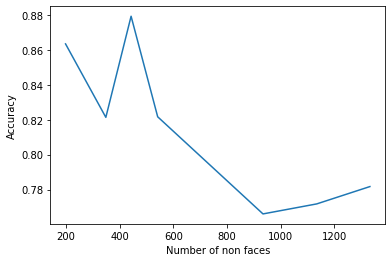

In [59]:
plt.plot(num_nonfaces , accur_afterLDA)
plt.xlabel('Number of non faces')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
####################################################################################################################

In [ ]:
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
W = LDA(arr, noOfDims=2)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES

[[124.58465011]
 [123.83069977]
 [122.79458239]
 ...
 [103.5282167 ]
 [102.64559819]
 [102.23024831]]


In [ ]:
#### 7.iii
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
acc=[]
s=[]
f=[]
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, labels_train)
#before reduction
#pred = knn.predict(X_test)
#print('labels test',labels_test)
#print(pred)
knn.score(X_test, labels_test)


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_red, labels_train)
print(knn.score(X_test_red, labels_test))
pred = knn.predict(X_test_red)
print(accuracy_score(pred,labels_test))
acc.append(accuracy_score(pred,labels_test))

pred = knn.predict(X_test_red)
#print(X_test_red,labels_test)
#print('labels test',labels_test)
#print(pred)
for i in range(len(pred)):
    if(labels_test[i] != pred[i]):
       f.append([X_test_red[i],labels_test[i]])
    else:
       s.append([X_test_red[i],labels_test[i]])
print(f[0])       

0.7867298578199052
0.7867298578199052
[array([ 8.95092952, 61.22145525]), 1]


In [ ]:
def KMC(X, k, epsilon=0.01, maxIter=100):
  # initializing the error to be max at first
  err = float('inf')
  # randomly initializing the centroids
  centroid = [X[np.random.randint(0, len(X)-1)] for i in range(k)]
  while maxIter > 0 and err >= epsilon:
    maxIter -= 1
    cluster = [[] for i in range(k)]
    # copying the old centroids
    oldCentroid = copy.deepcopy(centroid)
    # assigning each data point to closest cluster
    for x in X:
      minn, j = float('inf'), 0
      for i in range(len(centroid)):
        dist = np.linalg.norm(x-centroid[i]) ** 2
        if dist < minn: minn, j = dist, i
      cluster[j].append(x)
    # updating the centroids
    for i in range(len(cluster)):
      if len(cluster[i]) != 0: centroid[i] = sum(cluster[i]) / len(cluster[i])
    # if centroids didn't change, then terminate
    err = 0
    for i in range(len(centroid)):
      err += np.linalg.norm(centroid[i] - oldCentroid[i]) ** 2
  return cluster

In [ ]:
reg = ks().fit(X_train, labels_train)
train_score = reg.score(X_train, labels_train)
test_score = reg.score(X_test, labels_test)
print("Before LDA")
print("Training Set Accuracy: {}\nTesting  Set Accuracy: {}\n\n\n".format(train_score, test_score))

print("After LDA")
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), W)
reg = ks().fit(X_train_red, labels_train)
train_score = reg.score(X_train_red, labels_train)
test_score = reg.score(X_test_red, labels_test)
print('200',accuracy_score(pred,labels_test))

#print(X_test_red)
print("Training Set Accuracy: {}\nTesting  Set Accuracy: {}".format(train_score, test_score))